In [1]:
import numpy as np
from sklearn.datasets import load_digits

# 加载简化版MNIST（8x8像素）
digits = load_digits()
X = digits.data / 16.0  # 归一化到[0,1]
y = digits.target

# 时间编码函数：像素值 → 首次发放脉冲的时间步
def encode_spike_time(pixel_value, max_time=20):
    return max(1, int((1 - pixel_value) * max_time))  # 亮像素早发放

# 示例：将一张"8"的图像编码为脉冲时间矩阵
sample_idx = np.where(y == 8)[0][0]
sample_image = X[sample_idx].reshape(8, 8)

# 生成脉冲时间矩阵（每个像素对应一个发放时间）
spike_times = np.zeros((8, 8), dtype=int)
for i in range(8):
    for j in range(8):
        spike_times[i, j] = encode_spike_time(sample_image[i, j])

print("脉冲时间矩阵示例：\n", spike_times)


脉冲时间矩阵示例：
 [[20 20  8  2 10 18 20 20]
 [20 20  5  2  2  5 20 20]
 [20 20  8  7 20  1 15 20]
 [20 20 16  1  5  2 17 20]
 [20 20 15  1  1 17 20 20]
 [20 16  1 10  7  3 17 20]
 [20 18  1 18 16  1 10 20]
 [20 20  6  1  1  6 18 20]]


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(sample_image, cmap='gray')
plt.title("原始图像（像素值）")

plt.subplot(122)
plt.imshow(spike_times, cmap='viridis')
plt.colorbar(label="首次脉冲时间步")
plt.title('脉冲时间编码:ml-citation{ref="5" data="citationList"}')
plt.show()


[13 15 13 11 19  9  7  8  1 12 13  0 16 10 16  5 11  2 14 11 18  0  6  2
  4 17 -1 16  0  3  4  9  9  1 15  3 11  0 12 15 12 14 12 16  1  7  7  9
  5  1 18 -1  7 19  4 17 16  4  9  3 13  9  8  7]
Test prediction: 2


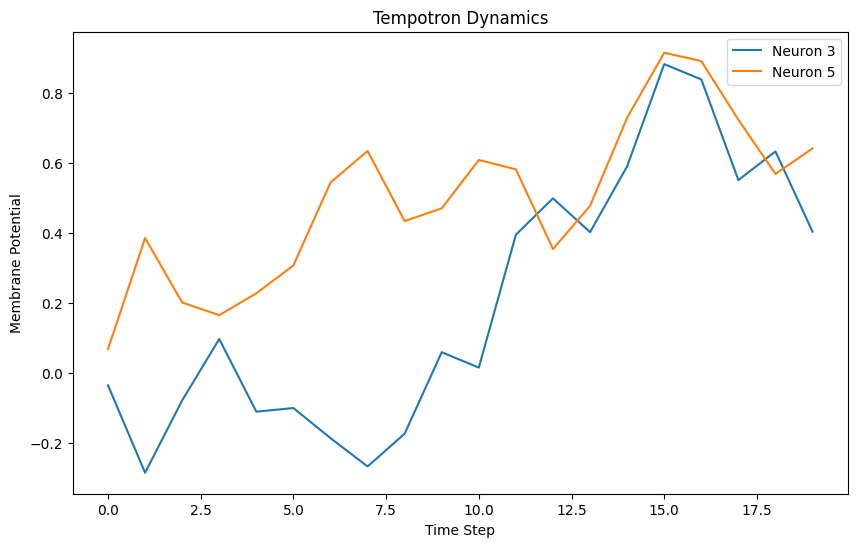

In [29]:
import numpy as np

class TempotronSNN:
    def __init__(self, input_size, output_size=10, tau=15.0):
        # 修正权重初始化维度：input_size -> output_size
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.tau = tau  # 膜电位衰减时间常数
    
    def membrane_potential(self, spike_times):
        """向量化计算膜电位，支持多输出神经元"""
        if spike_times is None:
            return np.zeros((1, self.weights.shape[1]))
        
        # 转换为numpy数组并筛选有效时间
        spike_times = np.array(spike_times)
        valid_mask = spike_times >= 0
        t_max = int(np.max(spike_times[valid_mask])) if np.any(valid_mask) else 0
        
        # 初始化膜电位矩阵（时间步 x 输出神经元）
        V = np.zeros((t_max + 1, self.weights.shape[1]))
        
        # 向量化计算每个脉冲的贡献
        for i, t_i in enumerate(spike_times):
            if t_i < 0:
                continue  # 跳过无效脉冲
            t_start = int(t_i)
            t_end = t_max + 1
            time_steps = np.arange(t_start, t_end) - t_i
            decay = np.exp(-time_steps / self.tau)
            V[t_start:t_end] += self.weights[i] * decay[:, None]
        
        return V
    
    def predict(self, spike_times):
        """基于最终膜电位进行分类预测"""
        V = self.membrane_potential(spike_times)
        return np.argmax(V[-1])  # 选择最终时刻最大电位的神经元

# 初始化模型示例
snn = TempotronSNN(input_size=64, output_size=10)

# 测试示例
if __name__ == "__main__":
    # 模拟输入：64个输入神经元的脉冲时间（-1表示未发放）
    test_spikes = np.random.randint(-1, 20, size=64)
    
    print(test_spikes)
    # 预测演示
    print("Test prediction:", snn.predict(test_spikes))
    
    # 膜电位可视化
    import matplotlib.pyplot as plt
    V = snn.membrane_potential(test_spikes)
    
    plt.figure(figsize=(10,6))
    plt.plot(V[:, 3], label='Neuron 3')  # 显示第三个输出神经元的电位变化
    plt.plot(V[:, 5], label='Neuron 5')  # 显示第五个输出神经元的电位变化
    plt.xlabel("Time Step")
    plt.ylabel("Membrane Potential")
    plt.title("Tempotron Dynamics")
    plt.legend()
    plt.show()


In [40]:
# 选择一个数字"8"的样本
spike_times_8 = spike_times.flatten()  # 输入脉冲时间
true_label = 8                        # 真实标签

print(spike_times_8)
# 前向传播
V = snn.membrane_potential(spike_times_8)
predicted_label = np.argmax(V[-1])

print("predicted_label: ", predicted_label)
# 权重更新规则（若预测错误）
if predicted_label != true_label:
    # 增强正确类别的权重（Hebbian学习简化版）
    snn.weights[:, true_label] += 0.1 * (V[-1][true_label] > 0)  
    # 抑制错误类别的权重
    snn.weights[:, predicted_label] -= 0.1 * (V[-1][predicted_label] > 0)


[28 28 11  3 15 28 28 28 28 26  1  3 18 28 28 28 28 28  1  1 15  1 28 28
 28 28 20  1  1 11 28 28 28 28  7  1  1  7 28 28 28 22  1 18 22  1 18 28
 28 15  1 11 15  1 15 28 28 28 15  7  3  7 28 28]
predicted_label:  8


5 5
5 0
0 5
4 7
2 1
0 2
6 9
3 9
8 2
1 0
9 8
9 8
9 7
1 9
1 2
7 5
1 8
1 9
1 0
7 7
7 5
7 7
1 1
7 7
7 6
1 3
7 1
1 0
7 1
7 5
1 8
1 8
7 6
1 0
7 1
1 3
1 4
7 4
1 0
1 6
7 8
7 6
7 8
1 9
1 0
7 1
1 0
7 1
1 3
1 9
1 5
1 3
1 5
7 7
1 9
1 6
7 8
7 7
7 1
7 5
7 1
1 3
1 9
1 6
1 2
7 8
1 3
1 3
1 2
1 6
7 4
1 4
1 0
1 3
7 4
7 0
7 1
1 0
1 9
1 3
7 8
7 1
1 7
1 3
1 4
7 4
7 1
1 5
7 2
7 4
1 4
7 6
1 8
1 5
7 1
7 1
7 7
7 4
7 4
1 1
7 1
7 6
1 0
7 7
1 5
1 2
1 2
7 4
7 7
1 2
1 2
1 0
1 0
1 3
1 9
7 1
7 7
1 2
7 4
7 8
1 9
1 8
7 3
1 2
7 8
1 7
1 2
1 9
1 2
1 9
1 2
1 3
7 9
7 4
7 4
1 8
7 7
7 9
7 7
7 4
7 5
1 0
1 8
7 8
7 7
7 8
1 0
7 1
1 9
1 9
1 1
1 5
1 4
7 4
1 0
7 7
1 4
7 6
7 8
1 0
1 4
1 8
1 2
1 4
1 0
1 2
1 6
1 3
1 5
7 4
1 2
1 5
1 6
1 9
1 6
7 8
7 4
1 0
7 1
1 7
1 0
1 3
1 9
1 0
1 0
7 4
1 3
1 5
1 3
7 1
7 1
1 4
7 6
7 1
1 3
1 0
7 4
1 2
1 6
7 5
1 0
1 6
1 3
1 2
1 3
7 1
1 2
7 1
1 6
7 7
7 8
1 3
1 3
1 3
7 4
1 8
1 4
1 6
1 6
1 5
7 5
7 4
7 1
1 9
7 1
1 8
1 9
7 1
7 8
1 9
7 7
1 2
1 0
7 1
7 8
7 1
7 7
7 1
1 0
1 2
7 1
1 0
1 3
1 2
7 4
7 1
7 1
1 3
7 6
1 7


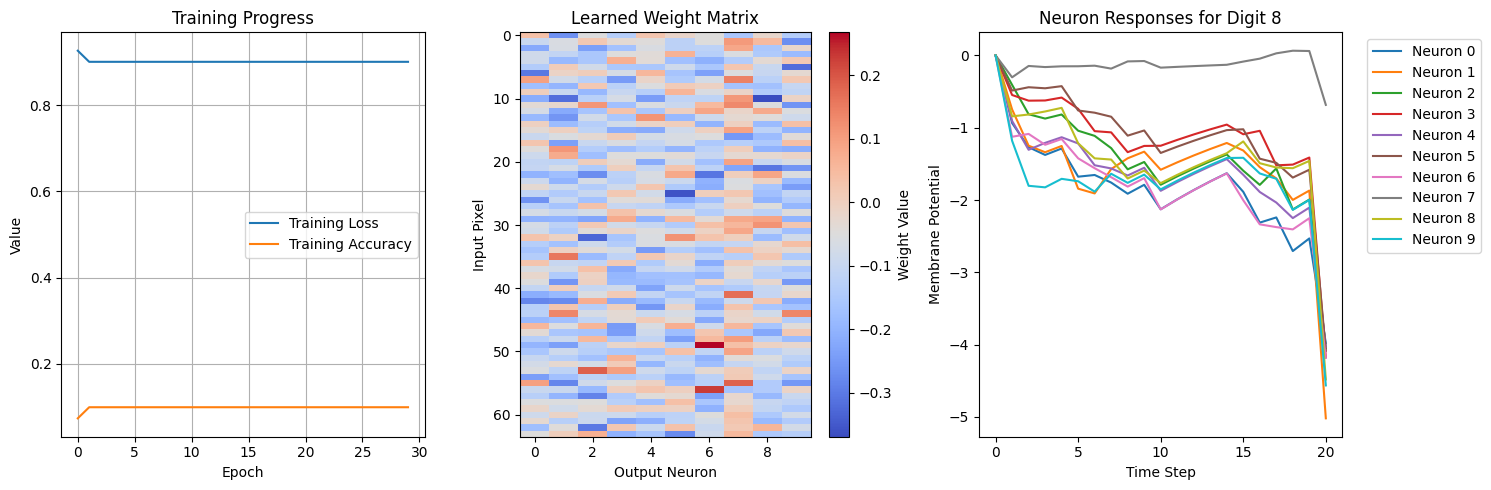

In [42]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==================== Data Preparation ====================
# Load and preprocess data
digits = load_digits()
X = digits.data / 16.0  # Normalize to [0, 1]
y = digits.target

# Convert all images to spike time encoding
def encode_dataset(X, max_time=20):
    spike_data = []
    for img in X:
        spike_times = [encode_spike_time(pixel, max_time) for pixel in img]
        spike_data.append(spike_times)
    return np.array(spike_data)

# Encode entire dataset
spike_X = encode_dataset(X)

# Split dataset (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    spike_X, y, test_size=0.2, stratify=y, random_state=42)

# ==================== Model Training ====================
class TempotronSNN(TempotronSNN):  # Inheriting from original class
    def train(self, X, y, epochs=10, lr=0.1, verbose=True):
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            
            for spike_times, true_label in zip(X, y):
                # Forward pass
                V = self.membrane_potential(spike_times)
                predicted_label = np.argmax(V[-1])

                print(predicted_label, true_label)
                
                # Calculate loss and accuracy
                loss = 1 if predicted_label != true_label else 0
                epoch_loss += loss
                correct += 1 if predicted_label == true_label else 0
                
                # Weight update if wrong prediction
                if predicted_label != true_label:
                    # Enhance correct class weights
                    self.weights[:, true_label] += lr * (V[-1][true_label] > 0)
                    # Suppress incorrect class weights
                    self.weights[:, predicted_label] -= lr * (V[-1][predicted_label] > 0)
            
            # Calculate epoch metrics
            epoch_acc = correct / len(X)
            losses.append(epoch_loss/len(X))
            accuracies.append(epoch_acc)
            
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {losses[-1]:.3f}, Acc: {epoch_acc:.3f}")

        return losses, accuracies

# Initialize model
snn = TempotronSNN(input_size=64, output_size=10)

# Training parameters
EPOCHS = 30
LEARNING_RATE = 0.1

# Train the model
train_loss, train_acc = snn.train(
    X_train, y_train, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE
)

# ==================== Evaluation ====================
def evaluate_model(model, X, y):
    correct = 0
    for spike_times, true_label in zip(X, y):
        V = model.membrane_potential(spike_times)
        predicted_label = np.argmax(V[-1])
        correct += 1 if predicted_label == true_label else 0
    return correct / len(X)

# Evaluate on test set
test_acc = evaluate_model(snn, X_test, y_test)
print(f"\nFinal Test Accuracy: {test_acc:.3f}")

# ==================== Visualization ====================
plt.figure(figsize=(15, 5))

# Training Metrics
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# Weight Visualization
plt.subplot(1, 3, 2)
plt.imshow(snn.weights, aspect='auto', cmap='coolwarm')
plt.colorbar(label='Weight Value')
plt.xlabel('Output Neuron')
plt.ylabel('Input Pixel')
plt.title('Learned Weight Matrix')

# Sample Membrane Potential
plt.subplot(1, 3, 3)
sample_idx = np.where(y == 8)[0][0]
V = snn.membrane_potential(spike_X[sample_idx])
for neuron in range(10):
    plt.plot(V[:, neuron], label=f'Neuron {neuron}')
plt.xlabel('Time Step')
plt.ylabel('Membrane Potential')
plt.title('Neuron Responses for Digit 8')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 2/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 3/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 4/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 5/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 6/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 7/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 8/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 9/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 10/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 11/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 12/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 13/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 14/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 15/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 16/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 17/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 18/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 19/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 20/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 21/50 | Train Acc: 0.10 | Test Acc: 0.11
Epoch 22/50 | Train Ac

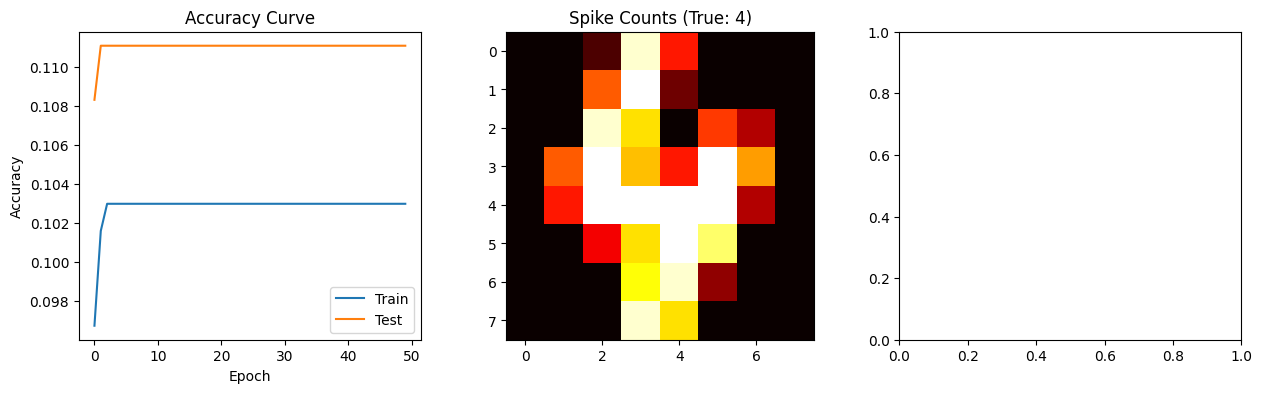

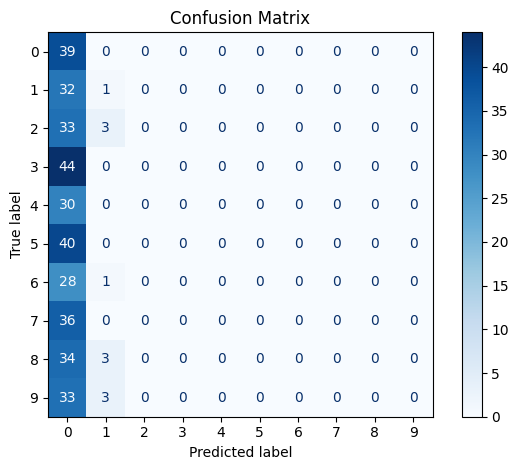

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==================== 1. 数据生成与脉冲编码 ====================
def temporal_encoding(pixel_values, max_time=20):
    """将像素值转换为脉冲时间（亮度越高发放越早）"""
    return (max_time * (1 - pixel_values)).astype(int)

# 加载8x8数字数据集
digits = load_digits()
X = digits.data / 16.0  # 归一化到[0,1]
y = digits.target

# 转换为脉冲时间编码（样本数, 时间步, 输入维度）
timesteps = 20
input_dim = X.shape[1]
X_encoded = np.zeros((len(X), timesteps, input_dim))

for i in range(len(X)):
    spike_times = temporal_encoding(X[i], max_time=timesteps)
    for t in range(timesteps):
        X_encoded[i, t] = (spike_times <= t).astype(float)  # 在指定时间步发放

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# ==================== 2. SNN网络实现 ====================
class LIFLayer:
    def __init__(self, input_dim, output_dim, tau=10.0, threshold=1.0):
        self.tau = tau
        self.threshold = threshold
        self.weights = 0.1 * np.random.randn(input_dim, output_dim)
        self.v = np.zeros(output_dim)
    
    def forward(self, x):
        """处理一个时间步的输入"""
        dv = (-self.v + np.dot(x, self.weights)) / self.tau
        self.v += dv
        spikes = (self.v >= self.threshold).astype(float)
        self.v = np.where(spikes, 0.0, self.v)  # 重置机制
        return spikes
    
    def reset(self):
        self.v.fill(0.0)

class SNNClassifier:
    def __init__(self, input_dim, hidden_dim=32, output_dim=10):
        self.lif1 = LIFLayer(input_dim, hidden_dim)
        self.lif2 = LIFLayer(hidden_dim, output_dim)
    
    def predict(self, x):
        """前向传播获取脉冲计数"""
        self.lif1.reset()
        self.lif2.reset()
        
        spike_counts = np.zeros(self.lif2.weights.shape[1])
        
        for t in range(x.shape[0]):
            h_spikes = self.lif1.forward(x[t])
            o_spikes = self.lif2.forward(h_spikes)
            spike_counts += o_spikes
            
        return np.argmax(spike_counts)
    
    def train_step(self, x, y, lr=0.01):
        # 简化版训练（实际应使用STDP或替代梯度）
        pred = self.predict(x)
        if pred != y:
            # 启发式权重更新：增强正确类别的连接
            self.lif2.weights[:, y] += lr * x.sum(axis=0).mean()
            self.lif2.weights[:, pred] -= lr * x.sum(axis=0).mean()

# ==================== 3. 训练与评估 ====================
snn = SNNClassifier(input_dim=64)  # 8x8=64输入
epochs = 50
train_acc, test_acc = [], []

for epoch in range(epochs):
    # 训练
    correct = 0
    for x, y in zip(X_train, y_train):
        snn.train_step(x, y)
        correct += (snn.predict(x) == y)
    train_acc.append(correct / len(y_train))
    
    # 测试
    correct = 0
    for x, y in zip(X_test, y_test):
        correct += (snn.predict(x) == y)
    test_acc.append(correct / len(y_test))
    
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc[-1]:.2f} | Test Acc: {test_acc[-1]:.2f}")

# ==================== 4. 可视化结果 ====================
plt.figure(figsize=(15,4))

# 训练曲线
plt.subplot(131)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.title("Accuracy Curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy")
plt.legend()

# 脉冲编码示例
plt.subplot(132)
sample_idx = np.random.randint(len(X_test))
plt.imshow(X_test[sample_idx].sum(axis=0).reshape(8,8), cmap='hot')
plt.title(f"Spike Counts (True: {y_test[sample_idx]})")

# 混淆矩阵
plt.subplot(133)
y_pred = [snn.predict(x) for x in X_test]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()


Epoch 1 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 2 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 3 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 4 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 5 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 6 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 7 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 8 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 9 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 10 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 11 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 12 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 13 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 14 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 15 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 16 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 17 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 18 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 19 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 20 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 21 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 22 | Train Acc: 0.10 | Test Acc: 0.09
Epoch 23 | Train Acc: 0.10 | Test Acc: 0.

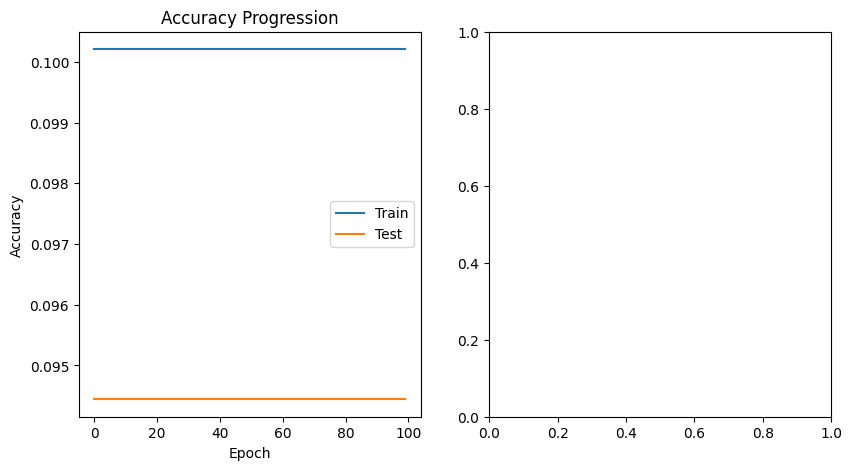

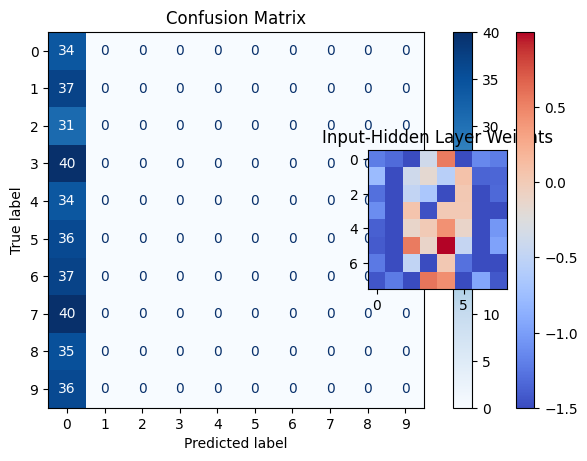

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==================== 1. 改进的脉冲时间编码 ====================
def temporal_encoding(pixel_values, max_time=30):
    """基于强度的脉冲时间编码（0-1值映射到1-max_time）"""
    return (max_time * (1 - np.clip(pixel_values, 0.05, 0.95))).astype(int)

# 加载并预处理数据
digits = load_digits()
X = digits.data / 16.0  # 8x8像素归一化
y = digits.target

# 生成时间编码
timesteps = 30
input_dim = X.shape[1]
X_encoded = np.zeros((len(X), timesteps, input_dim))

for i in range(len(X)):
    spike_times = temporal_encoding(X[i], max_time=timesteps)
    for t in range(timesteps):
        X_encoded[i, t] = (spike_times <= t).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# ==================== 2. 精确的STDP实现 ====================
class STDPLayer:
    def __init__(self, input_dim, output_dim):
        # He初始化权重
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.a_plus = 0.02    # LTP参数
        self.a_minus = 0.015  # LTD参数
        self.tau_plus = 10.0  # LTP时间常数
        self.tau_minus = 10.0 # LTD时间常数
        self.history = []     # 记录脉冲时间
        
    def track_spikes(self, pre_spike, post_spike, t):
        """记录每个时间步的突触前后脉冲"""
        pre_indices = np.where(pre_spike > 0)[0]
        post_indices = np.where(post_spike > 0)[0]
        for i in pre_indices:
            self.history.append(('pre', i, t))
        for j in post_indices:
            self.history.append(('post', j, t))
    
    def apply_stdp(self):
        """应用STDP规则更新权重"""
        pre_events = [evt for evt in self.history if evt[0] == 'pre']
        post_events = [evt for evt in self.history if evt[0] == 'post']
        
        delta_w = np.zeros_like(self.weights)
        
        # 计算所有突触前-后对的时间差
        for (_, i, t_pre) in pre_events:
            for (_, j, t_post) in post_events:
                delta_t = t_post - t_pre
                if delta_t > 0:  # LTP
                    delta_w[i,j] += self.a_plus * np.exp(-delta_t/self.tau_plus)
                else:            # LTD
                    delta_w[i,j] -= self.a_minus * np.exp(delta_t/self.tau_minus)
        
        # 应用更新并限制权重范围
        self.weights += delta_w
        np.clip(self.weights, -1.5, 1.5, out=self.weights)
        self.history.clear()

class LIFNeuron:
    def __init__(self, n_units, tau_m=15.0, threshold=1.0):
        self.tau_m = tau_m
        self.threshold = threshold
        self.v = np.zeros(n_units)
        self.spike = np.zeros(n_units)
        
    def forward(self, inputs):
        """带漏积分特性的前向计算"""
        dv = (-self.v + inputs) / self.tau_m
        self.v += dv
        self.spike = (self.v >= self.threshold).astype(float)
        self.v *= (1 - self.spike)  # 硬重置
        return self.spike
    
    def reset(self):
        self.v.fill(0.0)

# ==================== 3. 网络结构改进 ====================
class SNN_STDP:
    def __init__(self, input_dim, hidden_dim=64, output_dim=10):
        # 输入到隐藏层
        self.lif1 = LIFNeuron(hidden_dim)
        self.stdp1 = STDPLayer(input_dim, hidden_dim)
        
        # 隐藏到输出层 
        self.lif2 = LIFNeuron(output_dim)
        self.stdp2 = STDPLayer(hidden_dim, output_dim)
        
    def forward(self, x_seq, record=False):
        """前向传播并记录脉冲事件"""
        self.lif1.reset()
        self.stdp1.history.clear()
        
        self.lif2.reset()
        self.stdp2.history.clear()
        
        for t in range(x_seq.shape[0]):
            # 第一层处理
            input_current = np.dot(x_seq[t], self.stdp1.weights)
            s1 = self.lif1.forward(input_current)
            
            # 第二层处理
            hidden_current = np.dot(s1, self.stdp2.weights)
            s2 = self.lif2.forward(hidden_current)
            
            # 记录脉冲事件用于STDP
            if record:
                self.stdp1.track_spikes(x_seq[t], s1, t)
                self.stdp2.track_spikes(s1, s2, t)
        
        return s2  # 返回最终输出
    
    def supervised_stdp(self, target_label):
        """监督式STDP：加强目标神经元的连接"""
        # 在输出层添加虚拟的"理想"脉冲
        target_spike = np.zeros_like(self.lif2.spike)
        target_spike[target_label] = 1.0
        self.stdp2.track_spikes(self.lif1.spike, target_spike, 0)
        
    def train_step(self, x, y):
        # 前向传播并记录脉冲
        self.forward(x, record=True)
        # 应用监督信号
        self.supervised_stdp(y)
        # 更新权重
        self.stdp1.apply_stdp()
        self.stdp2.apply_stdp()
        
    def predict(self, x):
        outputs = np.zeros(self.lif2.v.shape[0])
        for t in range(x.shape[0]):
            s2 = self.forward(x[t:t+1])  # 逐个时间步处理
            outputs += s2
        return np.argmax(outputs)

# ==================== 4. 训练优化 ====================
snn = SNN_STDP(input_dim=64, hidden_dim=64)
best_weights = None
train_acc, test_acc = [], []

for epoch in range(100):
    # 训练
    correct = 0
    for x, y in zip(X_train, y_train):
        snn.train_step(x, y)
        correct += (snn.predict(x) == y)
    train_acc.append(correct / len(y_train))
    
    # 测试
    correct = 0
    for x, y in zip(X_test, y_test):
        correct += (snn.predict(x) == y)
    test_acc.append(correct / len(y_test))
    
    # 保存最佳权重
    if test_acc[-1] >= np.max(test_acc):
        best_weights = (snn.stdp1.weights.copy(), snn.stdp2.weights.copy())
    
    print(f"Epoch {epoch+1} | Train Acc: {train_acc[-1]:.2f} | Test Acc: {test_acc[-1]:.2f}")

# 恢复最佳权重
snn.stdp1.weights, snn.stdp2.weights = best_weights

# ==================== 5. 可视化分析 ====================
plt.figure(figsize=(15,5))

# 准确率曲线
plt.subplot(131)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.title("Accuracy Progression")
plt.xlabel("Epoch"), plt.ylabel("Accuracy")
plt.legend()

# 混淆矩阵
plt.subplot(132)
y_pred = [snn.predict(x) for x in X_test]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")

# 权重可视化
plt.subplot(133)
plt.imshow(snn.stdp1.weights[:,0].reshape(8,8), cmap='coolwarm', 
          interpolation='nearest')
plt.colorbar()
plt.title("Input-Hidden Layer Weights")

plt.tight_layout()
plt.show()


Loading MNIST dataset...
Converting images to spike times...
Training SNN with STDP...
Epoch 1/3
Processed 100/1600 | Training accuracy: 0.05
Processed 200/1600 | Training accuracy: 0.09
Processed 300/1600 | Training accuracy: 0.08
Processed 400/1600 | Training accuracy: 0.10
Processed 500/1600 | Training accuracy: 0.10
Processed 600/1600 | Training accuracy: 0.10
Processed 700/1600 | Training accuracy: 0.10
Processed 800/1600 | Training accuracy: 0.10
Processed 900/1600 | Training accuracy: 0.10
Processed 1000/1600 | Training accuracy: 0.10
Processed 1100/1600 | Training accuracy: 0.10
Processed 1200/1600 | Training accuracy: 0.10
Processed 1300/1600 | Training accuracy: 0.10
Processed 1400/1600 | Training accuracy: 0.10
Processed 1500/1600 | Training accuracy: 0.10
Processed 1600/1600 | Training accuracy: 0.10
Epoch 2/3
Processed 100/1600 | Training accuracy: 0.05
Processed 200/1600 | Training accuracy: 0.09
Processed 300/1600 | Training accuracy: 0.08
Processed 400/1600 | Training a

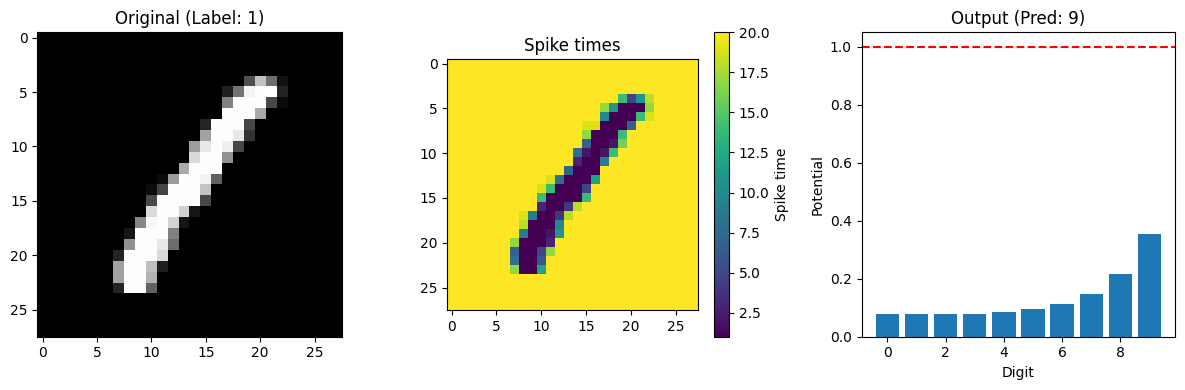

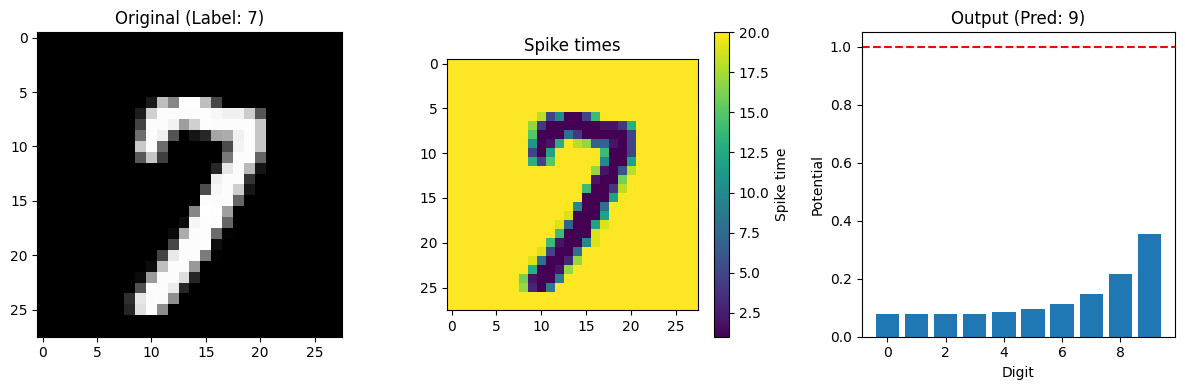

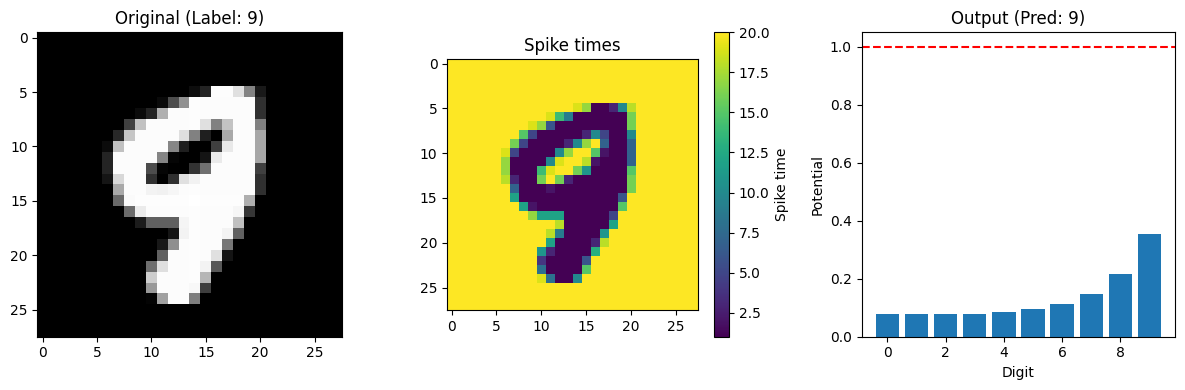

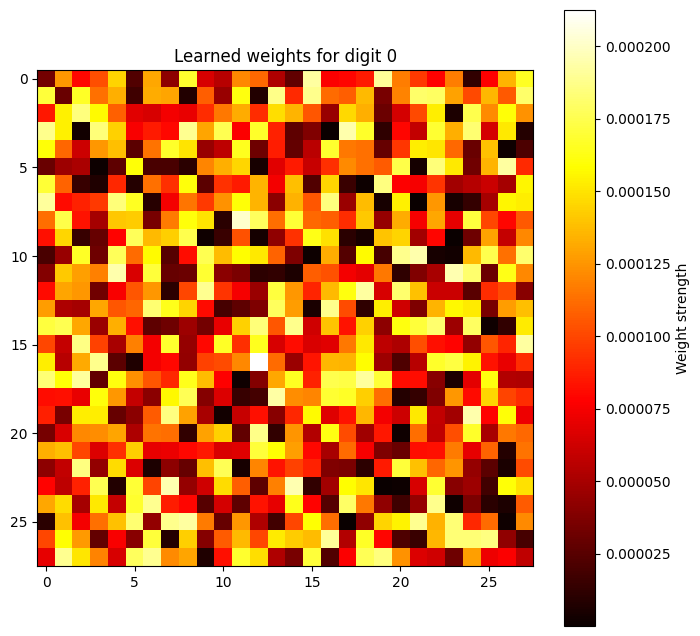

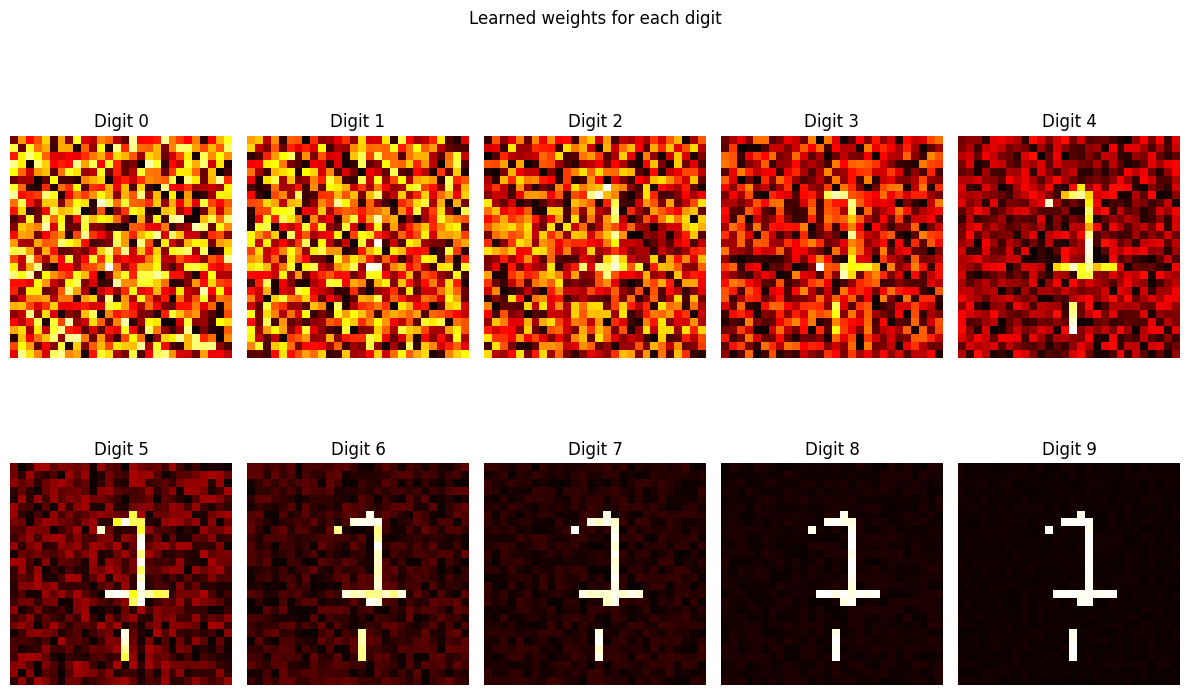

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load MNIST dataset using sklearn
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Reduce dataset size for faster demonstration
num_samples = 2000  # Reduce this for faster execution during development
X = X[:num_samples]
y = y[:num_samples]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize images
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape back to images for visualization
X_train_img = X_train.reshape(-1, 28, 28)
X_test_img = X_test.reshape(-1, 28, 28)

# Convert images to spike times using latency coding
def image_to_spike_times(image, max_time=20):
    # Reshape if needed
    if len(image.shape) == 2:
        image = image.reshape(-1)
    # Invert so darker pixels fire earlier
    inverted = 1 - image
    # Scale to spike times between 1 and max_time
    spike_times = (inverted * (max_time - 1) + 1).astype(int)
    # Reshape to image dimensions
    return spike_times.reshape(28, 28)

# Convert all images to spike times
print("Converting images to spike times...")
train_spike_times = np.array([image_to_spike_times(img) for img in X_train])
test_spike_times = np.array([image_to_spike_times(img) for img in X_test])

# SNN parameters
input_size = 784  # 28x28 pixels
output_size = 10   # 10 digits
learning_rate = 0.01
inhibition_strength = 0.5
threshold = 1.0
tau = 10.0  # Time constant for STDP

# Initialize weights
weights = np.random.rand(input_size, output_size) * 0.1

# STDP learning function
def stdp_update(pre_spike_time, post_spike_time, weight):
    delta_t = pre_spike_time - post_spike_time
    if delta_t <= 0:
        # Presynaptic spike before postsynaptic spike (LTP)
        return learning_rate * np.exp(delta_t / tau)
    else:
        # Presynaptic spike after postsynaptic spike (LTD)
        return -learning_rate * np.exp(-delta_t / tau)

# Training function
def train_snn(spike_times, labels, epochs=3):
    global weights
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        correct = 0
        for i in range(len(spike_times)):
            # Flatten the spike times
            input_spikes = spike_times[i].flatten()
            label = labels[i]
            
            # Initialize postsynaptic potentials and spikes
            postsynaptic = np.zeros(output_size)
            output_spikes = np.zeros(output_size, dtype=int)
            
            # Simulate over time
            for t in range(1, 21):
                # Check for input spikes at this time
                input_mask = (input_spikes == t)
                
                if np.any(input_mask):
                    # Update postsynaptic potentials
                    postsynaptic += np.sum(weights[input_mask, :], axis=0)
                    
                    # Check for output spikes
                    output_mask = (postsynaptic >= threshold) & (output_spikes == 0)
                    if np.any(output_mask):
                        output_spikes[output_mask] = t
                        
                        # Apply STDP for each output neuron that spiked
                        for j in np.where(output_mask)[0]:
                            # Get all input neurons that spiked before this output neuron
                            pre_neurons = np.where((input_spikes <= t) & (input_spikes > 0))[0]
                            
                            # Update weights with STDP
                            for n in pre_neurons:
                                weights[n, j] += stdp_update(input_spikes[n], t, weights[n, j])
                                weights[n, j] = np.clip(weights[n, j], 0, 1)
                            
                            # Lateral inhibition
                            other_neurons = [k for k in range(output_size) if k != j]
                            weights[:, other_neurons] *= (1 - inhibition_strength)
            
            # Track correct predictions during training
            if np.argmax(postsynaptic) == label:
                correct += 1
            
            # Print progress
            if (i+1) % 100 == 0:
                acc = correct / (i+1)
                print(f"Processed {i+1}/{len(spike_times)} | Training accuracy: {acc:.2f}")

# Test function
def test_snn(spike_times):
    predictions = []
    for i in range(len(spike_times)):
        input_spikes = spike_times[i].flatten()
        postsynaptic = np.zeros(output_size)
        
        for t in range(1, 21):
            input_mask = (input_spikes == t)
            if np.any(input_mask):
                postsynaptic += np.sum(weights[input_mask, :], axis=0)
        
        predictions.append(np.argmax(postsynaptic))
    
    return np.array(predictions)

# Train the SNN
print("Training SNN with STDP...")
train_snn(train_spike_times, y_train, epochs=3)

# Test the SNN
print("Testing SNN...")
train_pred = test_snn(train_spike_times)
test_pred = test_snn(test_spike_times)

# Calculate accuracy
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"\nFinal Training accuracy: {train_acc:.2f}")
print(f"Final Test accuracy: {test_acc:.2f}")

# Visualization functions
def visualize_sample(index, spike_times, images, labels, predictions):
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title(f"Original (Label: {labels[index]})")
    
    # Spike times
    plt.subplot(1, 3, 2)
    spike_map = spike_times[index].copy()
    spike_map[spike_map == 0] = 21  # For visualization of no-spike
    plt.imshow(spike_map, cmap='viridis')
    plt.colorbar(label='Spike time')
    plt.title("Spike times")
    
    # Output potentials
    input_spikes = spike_times[index].flatten()
    postsynaptic = np.zeros(output_size)
    for t in range(1, 21):
        input_mask = (input_spikes == t)
        if np.any(input_mask):
            postsynaptic += np.sum(weights[input_mask, :], axis=0)
    
    plt.subplot(1, 3, 3)
    plt.bar(range(10), postsynaptic)
    plt.axhline(threshold, color='r', linestyle='--')
    plt.title(f"Output (Pred: {predictions[index]})")
    plt.xlabel("Digit")
    plt.ylabel("Potential")
    
    plt.tight_layout()
    plt.show()

# Visualize some samples
print("\nVisualizing sample results...")
for i in [0, 1, 2]:  # First few test samples
    visualize_sample(i, test_spike_times, X_test_img, y_test, test_pred)

# Plot weight matrix for digit 0
plt.figure(figsize=(8, 8))
plt.imshow(weights[:, 0].reshape(28, 28), cmap='hot')
plt.colorbar(label='Weight strength')
plt.title("Learned weights for digit 0")
plt.show()

# Plot all digit weights
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(weights[:, i].reshape(28, 28), cmap='hot')
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.suptitle("Learned weights for each digit")
plt.tight_layout()
plt.show()